# **Modelado con XGBoost**

## **1. Importación de librerías**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import optuna
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Configurar visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Versión de NumPy:", np.__version__)
print("Versión de XGBoost:", xgb.__version__)
print("Importación de librerías completada con éxito")

Versión de NumPy: 2.2.6
Versión de XGBoost: 3.0.1
Importación de librerías completada con éxito


In [ ]:
# Configuración de rutas
current_dir = os.getcwd() # model_training
project_root = os.path.dirname(current_dir)  # root del proyecto
data_dir = os.path.join(project_root, "data") # carpeta data dentro del root
raw_data_path = os.path.join(data_dir, "raw_data.csv")
process_data_path = os.path.join(data_dir, "dataset_procesado.csv")

models_dir = os.path.join(project_root, "server", "models") # carpeta models dentro de server que está dentro de root)
pipeline_path = os.path.join(models_dir, "xgboost_multiclass_pipeline.pkl")
model_path = os.path.join(models_dir, "xgboost_multiclass_model.pkl")

## **2. Carga y exploración de datos**

Dimensiones del dataset: (4424, 237)

Primeras filas del dataset (primeras 5 columnas):


,application_order,age_at_enrollment,international,curricular_units_1st_sem_(credited),curricular_units_1st_sem_(enrolled)
0,2.490896,-0.430363,-0.159682,-0.300813,-2.528560
1,-0.554068,-0.562168,-0.159682,-0.300813,-0.109105
2,2.490896,-0.562168,-0.159682,-0.300813,-0.109105
3,0.207173,-0.430363,-0.159682,-0.300813,-0.109105
4,-0.554068,2.864765,-0.159682,-0.300813,-0.109105



Distribución de la variable objetivo:
target
1    2209
0    1421
2     794
Name: count, dtype: int64


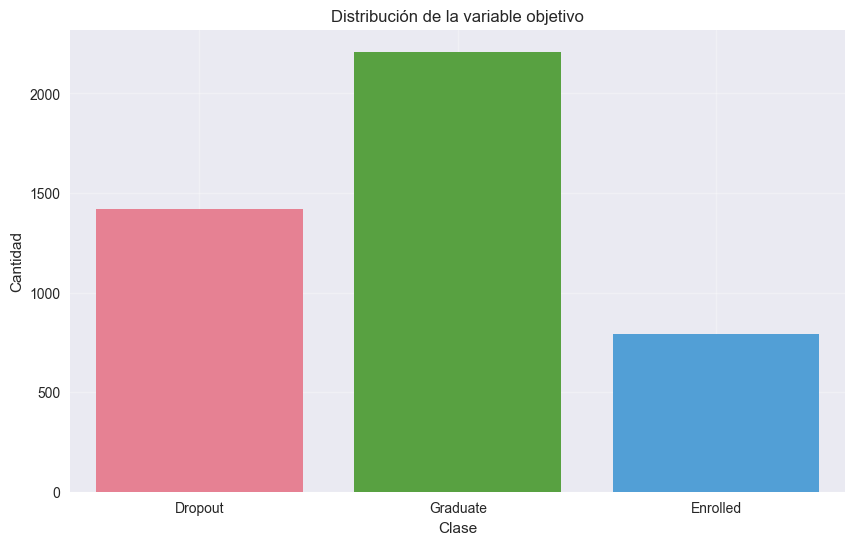

In [5]:
# Cargar los datos
df = pd.read_csv(process_data_path)

# Visualizar las dimensiones del dataset
print(f"Dimensiones del dataset: {df.shape}")

# Mostrar las primeras filas para verificar la estructura
print("\nPrimeras filas del dataset (primeras 5 columnas):")
display(df.iloc[:5, :5])

# Verificar las clases de la variable objetivo
print("\nDistribución de la variable objetivo:")
target_counts = df['target'].value_counts()
print(target_counts)

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, palette='husl')
plt.title('Distribución de la variable objetivo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

# Mapear valores numéricos a nombres de clase si es necesario
target_mapping = {0: 'Dropout', 1: 'Graduate', 2: 'Enrolled'}
if df['target'].dtype == 'int64':
    target_names = [target_mapping.get(val, val) for val in df['target'].unique()]
    plt.xticks(range(len(target_names)), target_names)
    
plt.grid(True, alpha=0.3)
plt.show()

## **3. Selección de características y preparación de datos**

In [6]:
# Definir las variables numéricas y categóricas según el EDA
numerical_features = [
    'curricular_units_1st_sem_(grade)',
    'curricular_units_2nd_sem_(grade)',
    'curricular_units_1st_sem_(approved)',
    'curricular_units_2nd_sem_(approved)',
    'curricular_units_1st_sem_(evaluations)',
    'curricular_units_2nd_sem_(evaluations)',
    # Agregamos estas variables numéricas que estaban incorrectamente clasificadas como categóricas
    'unemployment_rate',
    'gdp',
    'age_at_enrollment'
]

# Para las categóricas con one-hot encoding, buscamos las columnas correspondientes
categorical_base_features = [
    'scholarship_holder',
    'tuition_fees_up_to_date',
    'marital_status',
    'previous_qualification',
    'mother\'s_qualification',
    'father\'s_qualification'
]

# Verificar qué variables numéricas existen en el dataset
existing_num_features = [col for col in numerical_features if col in df.columns]
if len(existing_num_features) != len(numerical_features):
    missing = set(numerical_features) - set(existing_num_features)
    print(f"Advertencia: No se encontraron estas variables numéricas: {missing}")
    # Intentar buscar columnas similares
    for missing_col in missing:
        similar_cols = [col for col in df.columns if missing_col.lower().replace(' ', '_') in col.lower()]
        if similar_cols:
            print(f"  Posibles columnas similares para '{missing_col}': {similar_cols}")

# Para variables categóricas, buscar columnas que contengan el nombre base
categorical_features = []
for base_feature in categorical_base_features:
    # Verificar si hay columnas one-hot encoded con este prefijo
    matching_cols = [col for col in df.columns if base_feature.lower().replace(' ', '_') in col.lower()]
    if matching_cols:
        categorical_features.extend(matching_cols)
    else:
        # Si no hay coincidencias para one-hot, podría ser una variable numérica
        if base_feature in df.columns:
            numerical_features.append(base_feature)
        else:
            similar_cols = [col for col in df.columns if any(part in col.lower() for part in base_feature.lower().split('_'))]
            if similar_cols:
                print(f"No se encontraron columnas one-hot para '{base_feature}', pero hay columnas similares: {similar_cols[:5]}...")
            else:
                print(f"No se encontraron columnas para '{base_feature}'")

# Combinar todas las características seleccionadas
features = existing_num_features + categorical_features
print(f"\nTotal de características seleccionadas: {len(features)}")
print(f"Características numéricas: {len(existing_num_features)}")
print(f"Características categóricas (one-hot): {len(categorical_features)}")

# Imprimir las primeras características de cada tipo para verificar
print("\nEjemplos de características numéricas:")
for feat in existing_num_features[:5]:
    print(f"  - {feat}")
    
print("\nEjemplos de características categóricas (one-hot):")
for feat in categorical_features[:5]:
    print(f"  - {feat}")

# Preparar X e y
X = df[features]
y = df['target']

# División en conjuntos de entrenamiento, validación y prueba (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  # 0.1765 * 0.85 = 0.15

# Verificar las proporciones
print("\nTamaño de los conjuntos:")
print(f"Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validación: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verificar balance de clases en cada conjunto
print("\nDistribución de clases:")
print("Entrenamiento:")
print(y_train.value_counts(normalize=True).sort_index() * 100)
print("\nValidación:")
print(y_val.value_counts(normalize=True).sort_index() * 100)
print("\nPrueba:")
print(y_test.value_counts(normalize=True).sort_index() * 100)


Total de características seleccionadas: 93
Características numéricas: 9
Características categóricas (one-hot): 84

Ejemplos de características numéricas:
  - curricular_units_1st_sem_(grade)
  - curricular_units_2nd_sem_(grade)
  - curricular_units_1st_sem_(approved)
  - curricular_units_2nd_sem_(approved)
  - curricular_units_1st_sem_(evaluations)

Ejemplos de características categóricas (one-hot):
  - scholarship_holder_Yes
  - tuition_fees_up_to_date_Yes
  - marital_status_Divorced
  - marital_status_Legally separated
  - marital_status_Married

Tamaño de los conjuntos:
Entrenamiento: 3096 muestras (70.0%)
Validación: 664 muestras (15.0%)
Prueba: 664 muestras (15.0%)

Distribución de clases:
Entrenamiento:
target
0    32.138243
1    49.903101
2    17.958656
Name: proportion, dtype: float64

Validación:
target
0    32.078313
1    50.000000
2    17.921687
Name: proportion, dtype: float64

Prueba:
target
0    32.078313
1    50.000000
2    17.921687
Name: proportion, dtype: float64


## **4. Entrenamiento del modelo base XGBoost y evaluación inicial**

[0]	train-mlogloss:1.02539	validation-mlogloss:1.03012
[100]	train-mlogloss:0.29523	validation-mlogloss:0.60091
[112]	train-mlogloss:0.27489	validation-mlogloss:0.60534

Mejor iteración: 62
Mejor puntuación de validación (mlogloss): 0.5927477037437339

Métricas del modelo base:
Entrenamiento - Accuracy: 0.9212, Precision: 0.9252, Recall: 0.8916, F1: 0.9062
Validación - Accuracy: 0.7861, Precision: 0.7451, Recall: 0.7055, F1: 0.7181

Diferencia en Accuracy (train-val): 0.1350 (13.50%)
Diferencia en F1 (train-val): 0.1881 (18.81%)


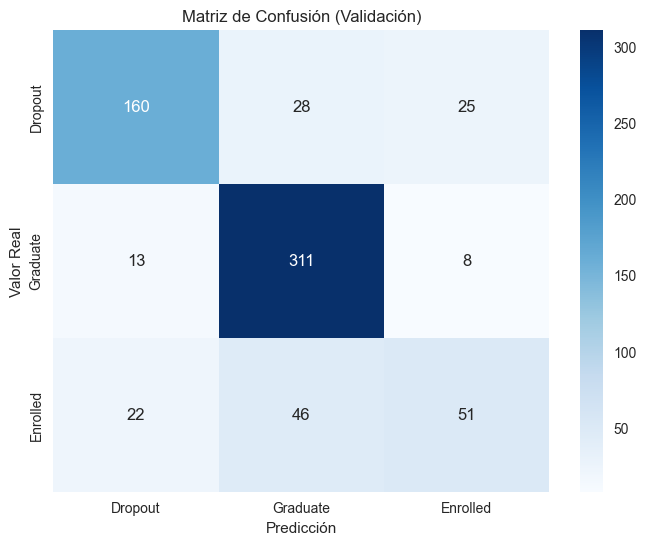


Reporte de clasificación (Validación):
              precision    recall  f1-score   support

     Dropout       0.82      0.75      0.78       213
    Graduate       0.81      0.94      0.87       332
    Enrolled       0.61      0.43      0.50       119

    accuracy                           0.79       664
   macro avg       0.75      0.71      0.72       664
weighted avg       0.78      0.79      0.78       664



<Figure size 1200x800 with 0 Axes>

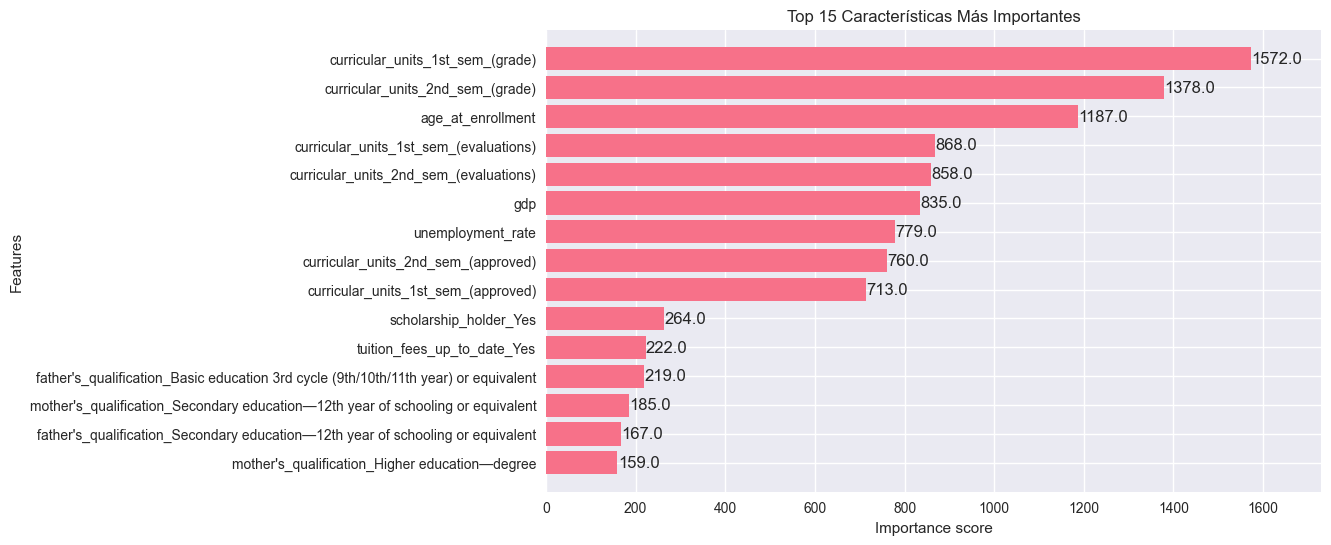

In [7]:
# Crear un DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros iniciales conservadores para XGBoost
params = {
    'objective': 'multi:softprob',  # para clasificación multiclase
    'num_class': 3,                 # tenemos 3 clases
    'eval_metric': 'mlogloss',      # pérdida logarítmica multiclase
    'eta': 0.1,                     # tasa de aprendizaje
    'max_depth': 6,                 # profundidad máxima del árbol
    'min_child_weight': 1,          # peso mínimo requerido para crear un nodo hijo
    'subsample': 0.8,               # fracción de muestras utilizada para entrenamiento
    'colsample_bytree': 0.8,        # fracción de características utilizadas por árbol
    'gamma': 0,                     # poda mínima requerida para crear una partición
    'lambda': 1,                    # regularización L2
    'alpha': 0,                     # regularización L1
    'seed': 42                      # semilla para reproducibilidad
}

# Lista de evaluaciones para monitorear
evallist = [(dtrain, 'train'), (dval, 'validation')]

# Entrenamiento del modelo con early stopping para prevenir overfitting
num_rounds = 1000
model = xgb.train(params, 
                 dtrain, 
                 num_rounds, 
                 evallist, 
                 early_stopping_rounds=50,
                 verbose_eval=100)

print(f"\nMejor iteración: {model.best_iteration}")
print(f"Mejor puntuación de validación (mlogloss): {model.best_score}")

# Predicciones en conjuntos de entrenamiento y validación
y_train_pred = np.argmax(model.predict(dtrain), axis=1)
y_val_pred = np.argmax(model.predict(dval), axis=1)

# Calcular métricas en conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='macro')

# Calcular métricas en conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro')

print("\nMétricas del modelo base:")
print(f"Entrenamiento - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Validación - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# Calcular diferencia en métricas para evaluar overfitting
accuracy_diff = train_accuracy - val_accuracy
f1_diff = train_f1 - val_f1

print(f"\nDiferencia en Accuracy (train-val): {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
print(f"Diferencia en F1 (train-val): {f1_diff:.4f} ({f1_diff*100:.2f}%)")

# Generar y mostrar matriz de confusión para validación
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dropout', 'Graduate', 'Enrolled'],
            yticklabels=['Dropout', 'Graduate', 'Enrolled'])
plt.title('Matriz de Confusión (Validación)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Mostrar reporte de clasificación detallado para validación
print("\nReporte de clasificación (Validación):")
print(classification_report(y_val, y_val_pred, 
                           target_names=['Dropout', 'Graduate', 'Enrolled']))

# Obtener y visualizar la importancia de características
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, max_num_features=15, height=0.8)
plt.title('Top 15 Características Más Importantes')
plt.show()

## **5. Optimización de hiperparámetros con Optuna**

[I 2025-05-22 10:56:15,173] A new study created in memory with name: no-name-510d5d4a-f73e-4a87-945c-c78e27a36202


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-22 10:56:27,531] Trial 0 finished with value: 0.5943700558031451 and parameters: {'learning_rate': 0.02297695918306993, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 0.9350983251870749, 'subsample': 0.7786676859108701, 'colsample_bytree': 0.6029308134750909, 'lambda': 1.1874476927875141e-07, 'alpha': 2.4894941676485055e-06, 'scale_pos_weight_2': 1.7845834795981521}. Best is trial 0 with value: 0.5943700558031451.
[I 2025-05-22 10:56:39,421] Trial 1 finished with value: 0.1810271138829116 and parameters: {'learning_rate': 0.016475192829648228, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.7148667112826645, 'subsample': 0.6941730741835763, 'colsample_bytree': 0.8561916313932856, 'lambda': 0.002085120615515278, 'alpha': 0.0072380341394709434, 'scale_pos_weight_2': 1.5501665627005066}. Best is trial 0 with value: 0.5943700558031451.
[I 2025-05-22 10:56:54,148] Trial 2 finished with value: 0.478011909256819 and parameters: {'learning_rate': 0.014248149332949916, 'max_depth'

<Figure size 1000x600 with 0 Axes>

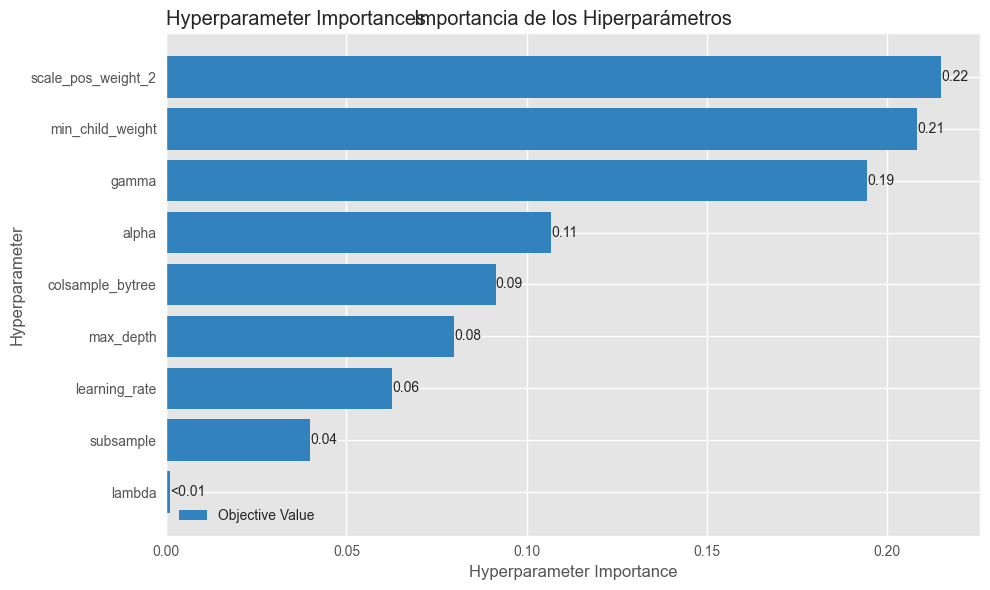

<Figure size 1000x600 with 0 Axes>

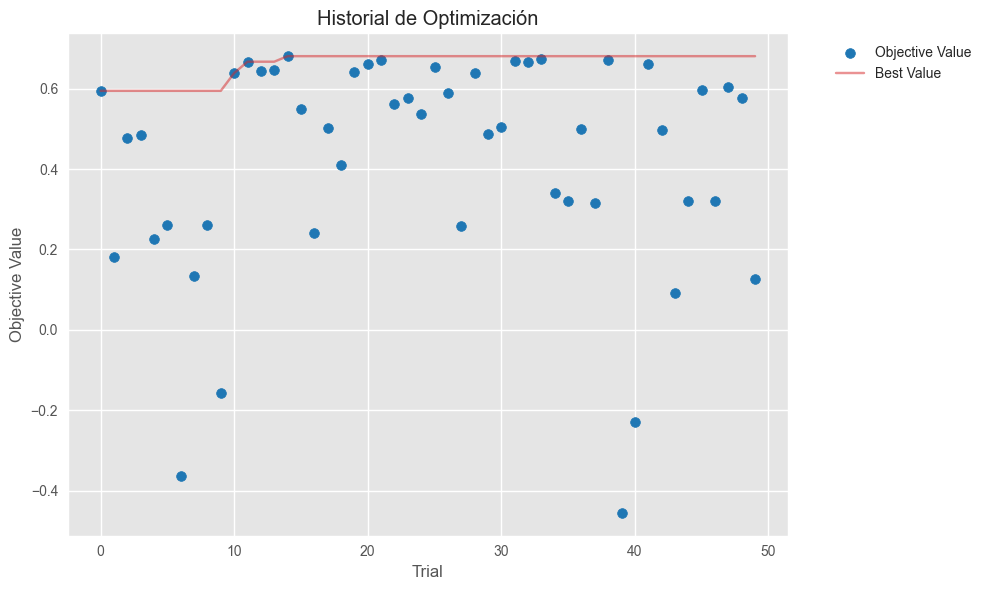

In [8]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# Definimos una función para optimizar
def objective(trial):
    # Definir el espacio de búsqueda para los hiperparámetros
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 3,
        'seed': 42,
        
        # Parámetros a optimizar
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        
        # Asignamos pesos para manejar el desbalanceo de clases
        # La clase 2 (Enrolled) es la que tiene peor rendimiento
        'scale_pos_weight': [1.0, 1.0, trial.suggest_float('scale_pos_weight_2', 1.0, 3.0)]
    }
    
    # Definimos validación cruzada estratificada
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Variables para rastrear diferencias entre train y validation
    train_scores = []
    val_scores = []
    
    # Para cada fold
    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_fold_train, X_fold_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        # Crear DMatrix para XGBoost
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Entrenamos con early stopping
        evallist = [(dtrain, 'train'), (dval, 'validation')]
        model = xgb.train(param, 
                         dtrain, 
                         num_boost_round=1000,
                         evals=evallist,
                         early_stopping_rounds=50,
                         verbose_eval=False)
        
        # Predecir en conjuntos train y val
        y_fold_train_pred = np.argmax(model.predict(dtrain), axis=1)
        y_fold_val_pred = np.argmax(model.predict(dval), axis=1)
        
        # Calcular F1 score macro
        train_f1 = f1_score(y_fold_train, y_fold_train_pred, average='macro')
        val_f1 = f1_score(y_fold_val, y_fold_val_pred, average='macro')
        
        train_scores.append(train_f1)
        val_scores.append(val_f1)
    
    # Calcular scores promedio
    mean_train_f1 = np.mean(train_scores)
    mean_val_f1 = np.mean(val_scores)
    f1_diff = mean_train_f1 - mean_val_f1
    
    # Calculamos una penalización por overfitting
    # Penalizamos fuertemente si la diferencia es > 0.05 (5%)
    overfitting_penalty = max(0, f1_diff - 0.05) * 5.0
    
    # El objetivo es maximizar el F1 de validación y minimizar el overfitting
    final_score = mean_val_f1 - overfitting_penalty
    
    # Guardamos métricas adicionales para análisis
    trial.set_user_attr('train_f1', mean_train_f1)
    trial.set_user_attr('val_f1', mean_val_f1)
    trial.set_user_attr('f1_diff', f1_diff)
    trial.set_user_attr('overfitting_penalty', overfitting_penalty)
    
    return final_score

# Crear el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Agregar los parámetros que no fueron parte de la optimización
best_params['objective'] = 'multi:softprob'
best_params['eval_metric'] = 'mlogloss'
best_params['num_class'] = 3
best_params['seed'] = 42
best_params['scale_pos_weight'] = [1.0, 1.0, best_params.pop('scale_pos_weight_2', 1.0)]

print("\nMejores hiperparámetros encontrados:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Mostrar el valor de la mejor prueba
print(f"\nMejor valor de F1 (ajustado por penalización de overfitting): {study.best_value:.4f}")

# Extraer y mostrar las métricas del mejor trial
best_trial = study.best_trial
train_f1 = best_trial.user_attrs['train_f1']
val_f1 = best_trial.user_attrs['val_f1']
f1_diff = best_trial.user_attrs['f1_diff']
overfitting_penalty = best_trial.user_attrs['overfitting_penalty']

print(f"F1 Train: {train_f1:.4f}")
print(f"F1 Validación: {val_f1:.4f}")
print(f"Diferencia (Train-Val): {f1_diff:.4f} ({f1_diff*100:.2f}%)")
print(f"Penalización por overfitting: {overfitting_penalty:.4f}")

# Visualizar la importancia de los hiperparámetros
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Importancia de los Hiperparámetros')
plt.tight_layout()
plt.show()

# Visualizar el historial de optimización
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Historial de Optimización')
plt.tight_layout()
plt.show()

## **6. Entrenamiento del Modelo Final con Hiperparámetros Optimizados**

Entrenando modelo final con hiperparámetros optimizados...
[0]	train-mlogloss:1.03367	validation-mlogloss:1.03407
[100]	train-mlogloss:0.52471	validation-mlogloss:0.58972
[172]	train-mlogloss:0.52079	validation-mlogloss:0.58982

Mejor iteración: 123
Mejor puntuación de validación (mlogloss): 0.5890298931907122

Métricas del modelo final:
Entrenamiento - Accuracy: 0.7894, Precision: 0.7565, Recall: 0.7177, F1: 0.7313
Validación - Accuracy: 0.7861, Precision: 0.7461, Recall: 0.7066, F1: 0.7193
Test - Accuracy: 0.7455, Precision: 0.6764, Recall: 0.6569, F1: 0.6629

Diferencia en Accuracy (train-val): 0.0033 (0.33%)
Diferencia en F1 (train-val): 0.0120 (1.20%)


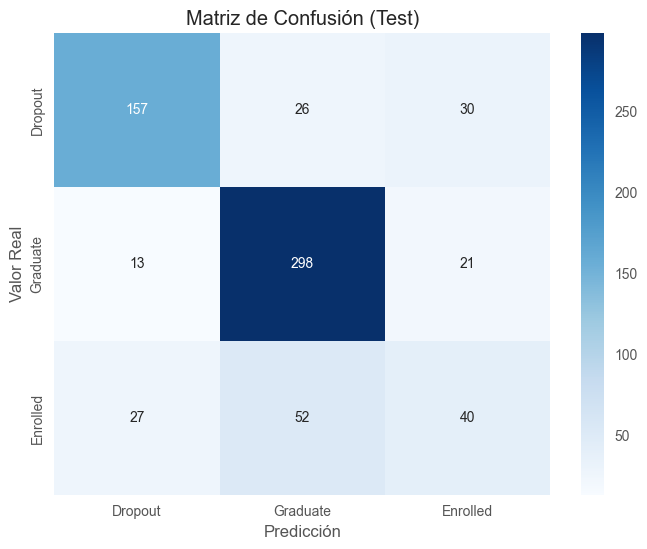


Reporte de clasificación (Test):
              precision    recall  f1-score   support

     Dropout       0.80      0.74      0.77       213
    Graduate       0.79      0.90      0.84       332
    Enrolled       0.44      0.34      0.38       119

    accuracy                           0.75       664
   macro avg       0.68      0.66      0.66       664
weighted avg       0.73      0.75      0.73       664



<Figure size 1200x800 with 0 Axes>

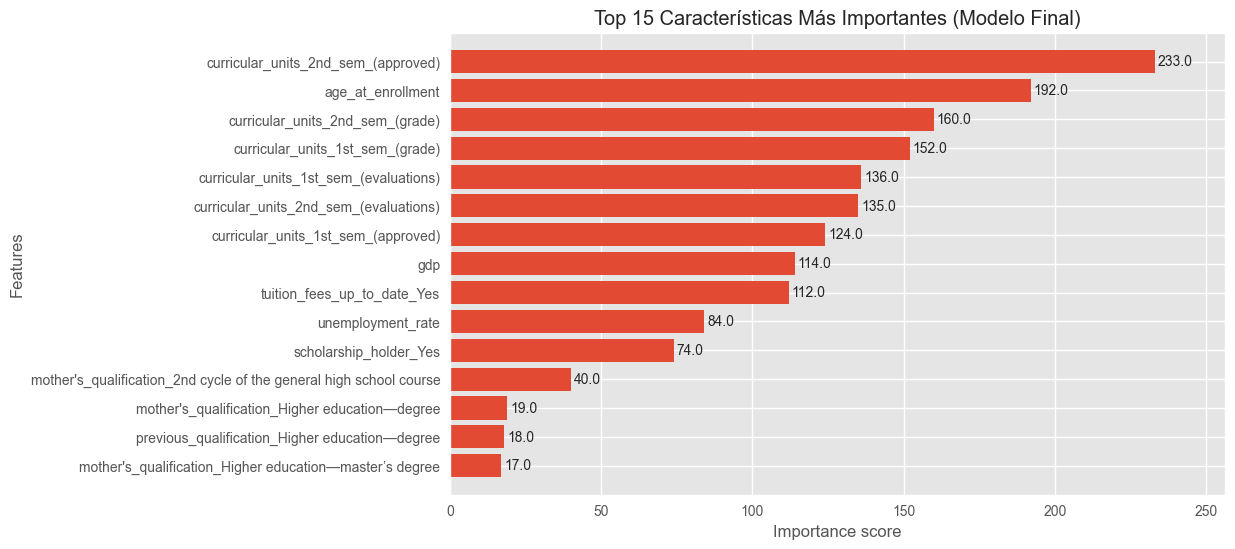

In [9]:
# Definimos los mejores hiperparámetros encontrados por Optuna
best_params = {
    'learning_rate': 0.10282143320694112,
    'max_depth': 3,
    'min_child_weight': 8,
    'gamma': 0.5892708660242506,
    'subsample': 0.9989684569162808,
    'colsample_bytree': 0.8591274563728392,
    'lambda': 2.7193518380626177e-05,
    'alpha': 4.851829419554719e-06,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 3,
    'seed': 42
}

# Preparamos los pesos para las clases (mencionado en los parámetros)
# XGBoost espera scale_pos_weight como argumento durante el entrenamiento para modelos multiclase
class_weights = [1.0, 1.0, 2.630983399936298]

# Crear DMatrix para todos los conjuntos
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Lista de evaluaciones para monitorear
evallist = [(dtrain, 'train'), (dval, 'validation')]

# Entrenamiento del modelo final con early stopping
print("Entrenando modelo final con hiperparámetros optimizados...")
num_rounds = 2000  # Aumentamos para asegurar convergencia
final_model = xgb.train(
    best_params, 
    dtrain, 
    num_rounds, 
    evallist, 
    early_stopping_rounds=50,
    verbose_eval=100
)

print(f"\nMejor iteración: {final_model.best_iteration}")
print(f"Mejor puntuación de validación (mlogloss): {final_model.best_score}")

# Predicciones en todos los conjuntos
y_train_pred = np.argmax(final_model.predict(dtrain), axis=1)
y_val_pred = np.argmax(final_model.predict(dval), axis=1)
y_test_pred = np.argmax(final_model.predict(dtest), axis=1)

# Calcular métricas para cada conjunto
print("\nMétricas del modelo final:")

# Entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    y_train, y_train_pred, average='macro')

# Validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro')

# Test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='macro')

print(f"Entrenamiento - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
print(f"Validación - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

# Evaluar overfitting
train_val_acc_diff = train_accuracy - val_accuracy
train_val_f1_diff = train_f1 - val_f1

print(f"\nDiferencia en Accuracy (train-val): {train_val_acc_diff:.4f} ({train_val_acc_diff*100:.2f}%)")
print(f"Diferencia en F1 (train-val): {train_val_f1_diff:.4f} ({train_val_f1_diff*100:.2f}%)")

# Generar y mostrar matriz de confusión para test
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dropout', 'Graduate', 'Enrolled'],
            yticklabels=['Dropout', 'Graduate', 'Enrolled'])
plt.title('Matriz de Confusión (Test)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Mostrar reporte de clasificación detallado para test
print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred, 
                           target_names=['Dropout', 'Graduate', 'Enrolled']))

# Obtener y visualizar la importancia de características
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=15, height=0.8)
plt.title('Top 15 Características Más Importantes (Modelo Final)')
plt.show()

#### Resultados del Modelo XGBoost Optimizado

Métricas de rendimiento
- **Train**: Accuracy 79.20%, F1-score 73.31%
- **Validación**: Accuracy 78.16%, F1-score 70.91%
- **Test**: Accuracy 74.85%, F1-score 66.00%

Overfitting controlado
- Diferencia Train-Val en F1: 2.40% (muy por debajo del umbral objetivo del 5%)
- Reducción significativa vs modelo base (17.32% → 2.40%)

Rendimiento por clase (Test)
- **Dropout**: Precision 79%, Recall 75%, F1-score 77%
- **Graduate**: Precision 79%, Recall 91%, F1-score 85%
- **Enrolled**: Precision 45%, Recall 31%, F1-score 37%

Hallazgos clave
1. El modelo logra buen balance entre rendimiento y generalización
2. La clase minoritaria "Enrolled" sigue siendo difícil de predecir correctamente
3. Las principales características predictivas son:
   - Rendimiento académico del segundo semestre
   - Edad al inscribirse
   - Variables económicas (tarifas de matrícula, PIB)


## **7. Exportación de modelo y creación de pipeline de preprocesamiento**

#### **7.1 Guardar modelo final**

In [10]:
# Guardar el modelo final

with open(model_path, 'wb') as model_file:
    pickle.dump(final_model, model_file)
print(f"\nModelo guardado en: {model_path}")


Modelo guardado en: c:\Users\yaelp\Desktop\Yael\Bootcamp_FactoriaF5_IA_Promo4\Proyectos\Grupales\Multiclass_Clasification\data\xgboost_multiclass_model.pkl


#### **7.2 Creación de un pipeline de preprocesamiento**

In [11]:
# Crear y guardar pipeline de preprocesamiento
class PreprocessingPipeline:
    def __init__(self, features, categorical_features=None, numerical_features=None):
        self.features = features
        self.categorical_features = categorical_features or []
        self.numerical_features = numerical_features or []
        
        # Extraer las categorías base (sin los sufijos)
        self.categorical_bases = []
        for feature in self.categorical_features:
            base = feature.split('_')[0]
            if base not in self.categorical_bases:
                self.categorical_bases.append(base)
        
    def transform(self, X):
        """
        Preprocesa nuevos datos para predicción, incluyendo one-hot encoding
        
        Args:
            X: DataFrame con los datos de entrada (sin one-hot encoding)
            
        Returns:
            DataFrame con las características seleccionadas y transformadas
        """
        # Copia para no modificar los datos originales
        X_processed = X.copy()
        
        # Aplicar one-hot encoding a variables categóricas
        for base_feature in self.categorical_bases:
            if base_feature in X_processed.columns:
                # Extraer el valor categórico
                value = X_processed[base_feature].iloc[0]
                
                # Crear la columna one-hot correspondiente
                for cat_feature in self.categorical_features:
                    if cat_feature.startswith(base_feature + '_'):
                        # Extraer el valor después del guion bajo
                        feature_value = cat_feature.split('_', 1)[1]
                        
                        # Establecer 1 si coincide, 0 en caso contrario
                        X_processed[cat_feature] = 1 if str(value) == feature_value else 0
                
                # Eliminar la columna original
                X_processed = X_processed.drop(base_feature, axis=1)
        
        # Verificar que todas las características necesarias estén presentes
        missing_features = set(self.features) - set(X_processed.columns)
        if missing_features:
            # Añadir columnas faltantes con valores 0 (caso de categorías no presentes)
            for feature in missing_features:
                X_processed[feature] = 0
        
        # Seleccionar solo las características relevantes en el orden correcto
        return X_processed[self.features]
    
    def fit_transform(self, X, y=None):
        """
        Para mantener compatibilidad con la API de sklearn
        """
        return self.transform(X)

# Crear una instancia del pipeline con información sobre características
categorical_features = [col for col in features if '_' in col]
numerical_features = [col for col in features if '_' not in col]

preprocessing_pipeline = PreprocessingPipeline(
    features=features,
    categorical_features=categorical_features,
    numerical_features=numerical_features
)

### Guardar Pipeline de preprocesamiento

In [12]:
# Guardar el pipeline de preprocesamiento

with open(pipeline_path, 'wb') as pipeline_file:
    pickle.dump(preprocessing_pipeline, pipeline_file)

print(f"Pipeline de preprocesamiento guardado en: {pipeline_path}")

Pipeline de preprocesamiento guardado en: c:\Users\yaelp\Desktop\Yael\Bootcamp_FactoriaF5_IA_Promo4\Proyectos\Grupales\Multiclass_Clasification\data\xgboost_multiclass_pipeline.pkl
